# Project = Information Retreival

## Preparations
* Put all your imports, and path constants in the next cells
* Make sure all your path constants are **relative to** ***DATA_DIR*** and **NOT hard-coded** in your code.

In [ ]:
!pip install whoosh
!pip install pytrec_eval
!pip install wget

     |████████████████████████████████| 471kB 2.8MB/s 
  Created wheel for pytrec-eval: filename=pytrec_eval-0.5-cp36-cp36m-linux_x86_64.whl size=263790 sha256=eaa812456e06b6f64967fd17c538d2d083b6b2ebb502092640fc02155263ae13
  Stored in directory: /root/.cache/pip/wheels/55/66/40/1779aa0a8eb66e088669befe286f695cdfe420ba91ce662127
Successfully built pytrec-eval
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=6e7d9b34681ad209404a822bb19ede7474e0cc3e21cf56d5f462e2668af5d4f9
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import wget
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/government.zip", "government.zip")

'government.zip'

In [ ]:
!unzip government.zip

Archive:  government.zip
   creating: government/
  inflating: government/topics-with-full-descriptions.txt  
  inflating: government/gov.topics   
  inflating: government/gov.qrels    
   creating: government/documents/
   creating: government/documents/61/
  inflating: government/documents/61/G00-61-2800209  
  inflating: government/documents/61/G00-61-1192048  
  inflating: government/documents/61/G00-61-1118212  
  inflating: government/documents/61/G00-61-0749882  
  inflating: government/documents/61/G00-61-2230501  
  inflating: government/documents/61/G00-61-0680698  
  inflating: government/documents/61/G00-61-0551387  
  inflating: government/documents/61/G00-61-2575433  
  inflating: government/documents/61/G00-61-0469713  
  inflating: government/documents/61/G00-61-0280746  
  inflating: government/documents/61/G00-61-2574316  
  inflating: government/documents/61/G00-61-3933997  
  inflating: government/documents/61/G00-61-3290635  
  inflating: government/documents/61/G0

In [ ]:
# imports
# Put all your imports here
from whoosh import index, writing
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser
import os.path
from pathlib import Path
import tempfile
import subprocess
import pytrec_eval
import wget

from whoosh.qparser import FieldnameNode
from whoosh.qparser import TextNode
from whoosh import qparser
from whoosh import scoring
import matplotlib.pyplot as plt

import nltk
from nltk.stem import *
nltk.download("wordnet")
from nltk.corpus import stopwords

import numpy as np

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
DATA_DIR = "government"
#
# Put other path constants here
#
DOCUMENTS_DIR = os.path.join(DATA_DIR, "documents")
TOPIC_FILE = os.path.join(DATA_DIR, "gov.topics")
QRELS_FILE = os.path.join(DATA_DIR, "gov.qrels")

### Note 1

**map** - Mean Average Precision

**map** - It provides a number representing goodness of the sorted information retrieved. It is sum of the precisions divided by the total ground truth positives to give a better sense of the "goodness" of the order of the informataion retreived. It is helpful maximizing this would help people spend less time looking for relevant information on government websites.

## 2. Indexing and querying

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 1., define a Schema for the index                                                                       #
# --------------------------------------------------------------------------------------------------------#

mySchema = Schema(file_path = ID(stored=True),
                  file_content = TEXT(analyzer = RegexTokenizer()))

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 2. create the index using the schema defined in 1.                                                      #
# --------------------------------------------------------------------------------------------------------#

def createIndex(schema):
    # Generate a temporary directory for the index
    indexDir = tempfile.mkdtemp()

    # create and return the index
    return index.create_in(indexDir, schema)

# now, create the index at the path INDEX_DIR based on the new schema
myIndex = createIndex(mySchema)

INDEX_Q2 = myIndex # Replace None with your index for Q2

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 3. adding the files to the index created in 2.                                                          #
# --------------------------------------------------------------------------------------------------------#

def addFilesToIndex(indexObj, fileList):
    # open writer
    writer = writing.BufferedWriter(indexObj, period=None, limit=1000)

    try:
        # write each file to index
        for docNum, filePath in enumerate(fileList):
            with open(filePath, "r", encoding="utf-8") as f:
                fileContent = f.read()
                writer.add_document(file_path = filePath,
                                    file_content = fileContent)

                # print status every 1000 documents
                if (docNum+1) % 1000 == 0:
                    print("already indexed:", docNum+1)
        print("done indexing.")

    finally:
        # close the index
        writer.close()

# Build a list of files to index
filesToIndex = [str(filePath) for filePath in Path(DOCUMENTS_DIR).glob("**/*") if filePath.is_file()] 
# The glob module finds all the pathnames matching a specified pattern
# https://docs.python.org/2/library/glob.html

addFilesToIndex(INDEX_Q2, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [ ]:
# Check the list
filesToIndex[:5]

['government/documents/62/G00-62-0870952',
 'government/documents/62/G00-62-0415887',
 'government/documents/62/G00-62-2860802',
 'government/documents/62/G00-62-2252378',
 'government/documents/62/G00-62-2501423']

In [ ]:
# count files to index
print("number of files:", len(filesToIndex))

number of files: 4078


In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 4. querying                                                                                             #
# --------------------------------------------------------------------------------------------------------#

# define a query parser for the field "file_content" in the index
QP_Q2 = QueryParser("file_content", schema=INDEX_Q2.schema)
SEARCHER_Q2 = INDEX_Q2.searcher()

In [ ]:
# # run a sample query for the phrase "item"
# sampleQuery = myQueryParser.parse("duck")
# sampleQueryResults = mySearcher.search(sampleQuery, limit=None)

# # inspect the result:
# # for each document print the rank and the score
# for (docnum, result) in enumerate(sampleQueryResults):
#     score = sampleQueryResults.score(docnum)
#     fileName = os.path.basename(result["file_path"])
#     print(fileName, docnum, score)

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 5. Evaluation using TREC_EVAL                                                                           #
# --------------------------------------------------------------------------------------------------------#

def pyTrecEval(topicFile, qrelsFile, queryParser, searcher):
    # Load topic file - a list of topics(search phrases) used for evalutation
    with open(topicFile, "r") as tf:
        topics = tf.read().splitlines()

    # create an output file to which we'll write our results
    tempOutputFile = tempfile.mkstemp()[1]
    with open(tempOutputFile, "w") as outputTRECFile:
        # for each evaluated topic:
        # build a query and record the results in the file in TREC_EVAL format
        for topic in topics:
            topic_id, topic_phrase = tuple(topic.split(" ", 1))
            #print(topic_id, topic_phrase)
            topicQuery = queryParser.parse(topic_phrase)
            topicResults = searcher.search(topicQuery, limit=None)
            for (docnum, result) in enumerate(topicResults):
                score = topicResults.score(docnum)
                #print("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
                outputTRECFile.write("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
    with open(qrelsFile, 'r') as f_qrel:
        qrel = pytrec_eval.parse_qrel(f_qrel)

    with open(tempOutputFile, 'r') as f_run:
        run = pytrec_eval.parse_run(f_run)

    evaluator = pytrec_eval.RelevanceEvaluator(
        qrel, pytrec_eval.supported_measures)

    results = evaluator.evaluate(run)
    def print_line(measure, scope, value):
        print('{:25s}{:8s}{:.4f}'.format(measure, scope, value))

    for query_id, query_measures in results.items():
        for measure, value in query_measures.items():
            if measure == "runid":
              continue
            print_line(measure, query_id, value)
    for measure in query_measures.keys():
        if measure == "runid":
              continue
        print_line(
            measure,
            'all',
            pytrec_eval.compute_aggregated_measure(
                measure,
                [query_measures[measure]
                 for query_measures in results.values()]))

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 6. Modifying TREC_EVAL to get only map                                                                  #
# --------------------------------------------------------------------------------------------------------#

def pyTrecEvalmodified_map(topicFile, qrelsFile, queryParser, searcher):

    master_dict = {}                                              ############################### modification ############################
    # Load topic file - a list of topics(search phrases) used for evalutation
    with open(topicFile, "r") as tf:
        topics = tf.read().splitlines()

    # create an output file to which we'll write our results
    tempOutputFile = tempfile.mkstemp()[1]
    with open(tempOutputFile, "w") as outputTRECFile:
        # for each evaluated topic:
        # build a query and record the results in the file in TREC_EVAL format
        for topic in topics:
            topic_id, topic_phrase = tuple(topic.split(" ", 1))
            #print(topic_id, topic_phrase)
            topicQuery = queryParser.parse(topic_phrase)
            topicResults = searcher.search(topicQuery, limit=None)
            for (docnum, result) in enumerate(topicResults):
                score = topicResults.score(docnum)
                #print("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
                outputTRECFile.write("%s Q0 %s %d %lf test\n" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
    with open(qrelsFile, 'r') as f_qrel:
        qrel = pytrec_eval.parse_qrel(f_qrel)

    with open(tempOutputFile, 'r') as f_run:
        run = pytrec_eval.parse_run(f_run)

    evaluator = pytrec_eval.RelevanceEvaluator(
        qrel, pytrec_eval.supported_measures)

    results = evaluator.evaluate(run)
    def print_line(measure, scope, value):
        print('{:25s}{:8s}{:.4f}'.format(measure, scope, value))

    for query_id, query_measures in results.items():
        for measure, value in query_measures.items():
            if measure == "runid":
              continue
            elif measure == 'map':                          ############################### modification ############################
              master_dict[int(query_id)] = value            ############################### modification ############################

            #print_line(measure, query_id, value)
    for measure in query_measures.keys():
        if measure == "runid":
              continue
        elif measure == 'map':                              ############################### modification ############################
          all_map = pytrec_eval.compute_aggregated_measure( ############################### modification ############################
                measure,                                    ############################### modification ############################
                [query_measures[measure]                    ############################### modification ############################
                 for query_measures in results.values()])   ############################### modification ############################

        # print_line(
        #     measure,
        #     'all',
        #     pytrec_eval.compute_aggregated_measure(
        #         measure,
        #         [query_measures[measure]
        #          for query_measures in results.values()]))

    return master_dict, all_map

In [ ]:
q2_query_maps, q2_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q2, SEARCHER_Q2)

In [ ]:
# print the topic file on which we will be searching and evaluating the results
with open(TOPIC_FILE, "r") as f:
    print(f.read())


# col1 = query topic id
# col2 = query topic

1 mining gold silver coal
2 juvenile delinquency
4 wireless communications
6 physical therapists
7 cotton industry
9 genealogy searches
10 Physical Fitness
14 Agricultural biotechnology
16 Emergency and disaster preparedness assistance
18 Shipwrecks
19 Cybercrime, internet fraud, and cyber fraud
22 Veteran's Benefits
24 Air Bag Safety
26 Nuclear power plants
28 Early Childhood Education



In [ ]:
# print the first 10 lines in the qrels file
with open(QRELS_FILE, "r") as f:
    qrels10 = f.readlines()[:10]
    print("".join(qrels10))

# col1 = query topic id
# col2 = ignore
# col3 = document name
# col4 = relevance to query topic (0 = not relevant | 1 = relevant)

1 0 G00-00-0681214 0
1 0 G00-00-0945765 0
1 0 G00-00-1006224 1
1 0 G00-00-1591495 0
1 0 G00-00-2764912 0
1 0 G00-00-3253540 0
1 0 G00-00-3717374 0
1 0 G00-01-0270065 0
1 0 G00-01-0400712 0
1 0 G00-01-0682299 0



In [ ]:
pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q2, SEARCHER_Q2)

# col1 = evaluation metric
# col2 = query topic id (look for 'all' at the end)
# col3 = metric value

num_q                    1       1.0000
num_ret                  1       1.0000
num_rel                  1       5.0000
num_rel_ret              1       0.0000
map                      1       0.0000
gm_map                   1       -11.5129
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0000
iprec_at_recall_0.00     1       0.0000
iprec_at_recall_0.10     1       0.0000
iprec_at_recall_0.20     1       0.0000
iprec_at_recall_0.30     1       0.0000
iprec_at_recall_0.40     1       0.0000
iprec_at_recall_0.50     1       0.0000
iprec_at_recall_0.60     1       0.0000
iprec_at_recall_0.70     1       0.0000
iprec_at_recall_0.80     1       0.0000
iprec_at_recall_0.90     1       0.0000
iprec_at_recall_1.00     1       0.0000
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0000
P_30                     1       0.000

In [ ]:
def printRelName(topicFile, qrelsFile, queryParser, searcher, id):
  with open(topicFile, "r") as tf:
        topics = tf.read().splitlines()
  for topic in topics:
        topic_id, topic_phrase = tuple(topic.split(" ", 1))
        if topic_id == id:
          print("---------------------------Topic_id and Topic_phrase----------------------------------")
          print(topic_id, topic_phrase)
          topicQuery = queryParser.parse(topic_phrase)
          topicResults = searcher.search(topicQuery, limit=None)
          print("---------------------------Return documents----------------------------------")
          for (docnum, result) in enumerate(topicResults):
              score = topicResults.score(docnum)
              print("%s Q0 %s %d %lf test" % (topic_id, os.path.basename(result["file_path"]), docnum, score))
          print("---------------------------Relevant documents----------------------------------")
          with open(qrelsFile, 'r') as f_qrel:
            qrels = f_qrel.readlines()
            for i in qrels:
              qid, _, doc, rel = i.rstrip().split(" ")
              if qid == id and rel == "1":
                print(i.rstrip())

In [ ]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q2, SEARCHER_Q2, "26")

---------------------------Topic_id and Topic_phrase----------------------------------
26 Nuclear power plants
---------------------------Return documents----------------------------------
26 Q0 G00-61-1118212 0 25.225053 test
26 Q0 G00-76-3273936 1 23.814912 test
26 Q0 G00-01-3645577 2 22.681193 test
26 Q0 G00-84-2503293 3 22.639455 test
26 Q0 G00-49-0195605 4 22.506206 test
26 Q0 G00-30-0129773 5 22.470464 test
26 Q0 G00-97-1443049 6 22.048298 test
26 Q0 G00-73-1499832 7 21.748460 test
26 Q0 G00-08-2701029 8 21.451529 test
26 Q0 G00-50-2186799 9 21.295502 test
26 Q0 G00-30-1518511 10 20.813328 test
26 Q0 G00-15-0501460 11 20.707036 test
26 Q0 G00-11-0770745 12 20.420555 test
26 Q0 G00-03-2200929 13 20.200627 test
26 Q0 G00-72-1085257 14 19.836718 test
26 Q0 G00-05-1894408 15 19.228168 test
26 Q0 G00-64-3503951 16 18.457268 test
26 Q0 G00-13-1543158 17 18.416715 test
26 Q0 G00-50-1075346 18 17.385842 test
26 Q0 G00-11-1650256 19 17.310835 test
26 Q0 G00-76-2323292 20 10.320647 test
26

## Analysis of the model

In [ ]:
QP_Q2.parse(u"Nuclear power plants")

And([Term('file_content', 'Nuclear'), Term('file_content', 'power'), Term('file_content', 'plants')])

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 1. get file path of false positive and false negative                                                   #
# --------------------------------------------------------------------------------------------------------#

#------assigning variables here----------
fp1 = "G00-61-1118212"
fn1 = "G00-92-1620651"
topicid_phrase = '26 Nuclear power plants'
parsed_phrase = 'Nuclear power plants'
#----------------------------------------

def IR_results_analyzer(filesToIndex,fp1,fn1,topicid_phrase,parsed_phrase,
                        SEARCHER_Q2,
                        INDEX_Q2):

  # get file path
  for filep in filesToIndex:
    if fp1 in filep:
      false_positive_path = filep

    elif fn1 in filep:
      false_negative_path = filep

  docnum_fp = SEARCHER_Q2.document_number(file_path=false_positive_path)
  docnum_fn = SEARCHER_Q2.document_number(file_path=false_negative_path)

  # --------------------------------------------------------------------------------------------------------#
  # 2. make temporary index for analysis purposes                                                           #
  # --------------------------------------------------------------------------------------------------------#

  READER_Q2 = INDEX_Q2.reader()

  INDEX_Q2_analysis_fp = createIndex(mySchema)
  addFilesToIndex(INDEX_Q2_analysis_fp, [filesToIndex[docnum_fp]])
  READER_Q2_analysis_fp = INDEX_Q2_analysis_fp.reader()

  INDEX_Q2_analysis_fn = createIndex(mySchema)
  addFilesToIndex(INDEX_Q2_analysis_fn, [filesToIndex[docnum_fn]])
  READER_Q2_analysis_fn = INDEX_Q2_analysis_fn.reader()

  # --------------------------------------------------------------------------------------------------------#
  # 3. Analysis of documents                                                                               #
  # --------------------------------------------------------------------------------------------------------#

  print ('\n-------------- Topic ID and Phrase -----------------------------')
  print (topicid_phrase)
  print ('Parsed topic phrase =', parsed_phrase)

  print ('\n-------------- False Positive Docment analysis -----------------')
  print ('Document analysed =', fp1)
  print ('Total words in above doc =', INDEX_Q2_analysis_fp.field_length("file_content"))
  print ('Total Unique words in above doc =', len(set(READER_Q2_analysis_fp.field_terms("file_content"))))
  topic_tokens = parsed_phrase.split()
  print ('This doc Occurance of', "'",topic_tokens[0], "'", '=', READER_Q2_analysis_fp.term_info("file_content", topic_tokens[0]).weight())
  print ('This doc Occurance of', "'",topic_tokens[1], "'", '=', READER_Q2_analysis_fp.term_info("file_content", topic_tokens[1]).weight())
  print ('This doc Occurance of', "'",topic_tokens[2], "'", '=', READER_Q2_analysis_fp.term_info("file_content", topic_tokens[2]).weight())

  print ('\n-------------- False Negative Docment analysis -----------------')
  print ('Document analysed =', fn1)
  print ('Total words in above doc =', INDEX_Q2_analysis_fn.field_length("file_content"))
  print ('Total Unique words in above doc =', len(set(READER_Q2_analysis_fn.field_terms("file_content"))))
  topic_tokens = parsed_phrase.split()
  print ('This doc Occurance of', "'",topic_tokens[0], "'", '=', READER_Q2_analysis_fn.term_info("file_content", topic_tokens[0]).weight())
  print ('This doc Occurance of', "'",topic_tokens[1], "'", '=', READER_Q2_analysis_fn.term_info("file_content", topic_tokens[1]).weight())
  try:
    print ('This doc Occurance of', "'",topic_tokens[2], "'", '=', READER_Q2_analysis_fn.term_info("file_content", topic_tokens[2]).weight())
  except:
    print ('This doc Occurance of', "'",topic_tokens[2], "'", '=', '0.0')

  print ('\n-------------- Overall Index Docment analysis -----------------')
  print ('total Documents analysed =', len(filesToIndex))
  print ('Total words in above doc =', INDEX_Q2.field_length("file_content"))
  print ('Total Unique words in above doc =', len(set(READER_Q2.field_terms("file_content"))))
  topic_tokens = parsed_phrase.split()
  print ('This doc Occurance of', "'",topic_tokens[0], "'", '=', READER_Q2.term_info("file_content", topic_tokens[0]).weight())
  print ('This doc Occurance of', "'",topic_tokens[1], "'", '=', READER_Q2.term_info("file_content", topic_tokens[1]).weight())
  print ('This doc Occurance of', "'",topic_tokens[2], "'", '=', READER_Q2.term_info("file_content", topic_tokens[2]).weight()) 
  print('Distinctive terms are =', READER_Q2.most_distinctive_terms("file_content", number=5))

In [ ]:
IR_results_analyzer(filesToIndex,fp1,fn1,topicid_phrase,parsed_phrase,
                        SEARCHER_Q2,
                        INDEX_Q2)

done indexing.
done indexing.

-------------- Topic ID and Phrase -----------------------------
26 Nuclear power plants
Parsed topic phrase = Nuclear power plants

-------------- False Positive Docment analysis -----------------
Document analysed = G00-61-1118212
Total words in above doc = 478
Total Unique words in above doc = 222
This doc Occurance of ' Nuclear ' = 6.0
This doc Occurance of ' power ' = 8.0
This doc Occurance of ' plants ' = 7.0

-------------- False Negative Docment analysis -----------------
Document analysed = G00-92-1620651
Total words in above doc = 1375
Total Unique words in above doc = 624
This doc Occurance of ' Nuclear ' = 13.0
This doc Occurance of ' power ' = 1.0
This doc Occurance of ' plants ' = 0.0

-------------- Overall Index Docment analysis -----------------
total Documents analysed = 4078
Total words in above doc = 2165181
Total Unique words in above doc = 102224
This doc Occurance of ' Nuclear ' = 573.0
This doc Occurance of ' power ' = 680.0
This d

### Note 2

1. **map** = 0.1971

### Note 2

The topics which specifically performed badly are as follows. These topics had a **map of 0** hence these **performed poorly.**

1. 1 mining gold silver coal
2. 2 juvenile delinquency
3. 6 physical therapists
4. 7 cotton industry
5. 9 genealogy searches
6. 16 Emergency and disaster preparedness assistance
7. 28 Early Childhood Education

The following topics had a **map of 1**, which means the model **peformance was good.**

1. 18 Shipwrecks
2. 24 Air Bag Safety


## 3. Improving performance

### Note 3

The whoosh baseline model performed poorly since the MAP was just 0.1971 which is quite low. For further analysis where the model went wrong, query topics are chosen. 

For evaluation of the poor performace of the model, **query 26 is chosen for indepth analysis.**

**Query 26** is chosen since it has an MAP of 0.1111, and in the retrieved document, it contains true positive, false positive, false negative.

The output is as follows - (first 3 output are chosen for the analysis)

.

---------------------------Topic_id and Topic_phrase---------------------------

26 Nuclear power plants

---------------------------Return documents----------------------------------

26 Q0 G00-61-1118212 0 25.225053 test = (false positive)

26 Q0 G00-76-3273936 1 23.814912 test = (false positive)

26 Q0 G00-01-3645577 2 22.681193 test = (true positive)

....

---------------------------Relevant documents----------------------------------

26 0 G00-01-1806077 1 = (false negative)

26 0 G00-01-3645577 1 = (true positive)

26 0 G00-92-1620651 1 = (false negative)

.

### Analysis Report - 
-------------- Topic ID and Phrase -----------------------------

26 Nuclear power plants

.

-------------- False Positive Docment analysis -----------------

Document analysed = G00-61-1118212

Total words in above doc = 478

Total Unique words in above doc = 222

This doc Occurance of ' Nuclear ' = 6.0

This doc Occurance of ' power ' = 8.0

This doc Occurance of ' plants ' = 7.0

.

-------------- False Negative Docment analysis -----------------

Document analysed = G00-92-1620651

Total words in above doc = 1375

Total Unique words in above doc = 624

This doc Occurance of ' Nuclear ' = 13.0

This doc Occurance of ' power ' = 1.0

This doc Occurance of ' plants ' = 0.0

.

-------------- Overall Index Docment analysis -----------------

total Documents analysed = 4078

Total words in above doc = 2165181

Total Unique words in above doc = 102224

This doc Occurance of ' Nuclear ' = 573.0

This doc Occurance of ' power ' = 680.0

This doc Occurance of ' plants ' = 160.0

Distinctive terms are = [(15793.691041995347, b'the'), (12141.916574922074, b'and'), (11322.7204750335, b'in'), (11181.871195315607, b'of'), (10654.852924162624, b'a')]

.

The topic talks about the Operational and safety information associated with  nuclear power plants.

We know that the default ranking and scoring in whoosh is done based on **BM25**, where all the words are searched in a document irrespective of their relevant position. Hence the query is parsed and by default **"AND"** clause is added between each term of the query.

Upon analysis of the **false positive** cases it was found that, "Nuclear", "power", "plants" indivdually appeared 6,7 and 8 times resp. Also the both the term "Nuclear" and "nuclear" were there in the document, hence it would result in deflated term frequencies.

Upon analysis of the **false negative** cases it was found that, "power", "plants" indivdually appeared very few times with 'plants' not appearing at all. Instead it contained "Nuclear Reactor" and "Nuclear Energy" terms which mean the same but dont match in BM25 tfidf scoring. Also, the data is also quite less compared to the false positives

Upon analysis of the **true positive** cases it was found that, "nuclear", "power", "plants" indivdually appeared around 5 times each and together 3 times. Also, there was terms like "plant" and "plants" which created descrepancies.

Moreover the most distinctive words are the stop words, which might again hinder the search process of the query.

### Modifications Suggested:
1. **Lemmatization of query and content =**

This will help remove the difference between "plant" and "plants" hence will make the retrieval better

2. **Lowercasing of query and content =**

This will help remove the difference between "Nuclear" and "nuclear" hence will make the retreival better

3. **Remove stop words**

Stop words do not add much information to the query or the content, and hence must not be included for information retreival








In [ ]:
# Put your code for creating the index here (you can add more cells).
# Make sure you save the final index in the variable INDEX_Q3, your query parser in QP_Q3, and your searcher in SEARCHER_Q3

# --------------------------------------------------------------------------------------------------------#
# 1., define a Schema for the index                                                                       #
# --------------------------------------------------------------------------------------------------------#
ANALYZER_Q3 = RegexTokenizer() | LowercaseFilter() | StopFilter() | StemFilter()

mySchema_Q3 = Schema(file_path = ID(stored=True),
                  file_content = TEXT(analyzer = ANALYZER_Q3))

# --------------------------------------------------------------------------------------------------------#
# 2. create the index using the schema defined in 1.                                                      #
# --------------------------------------------------------------------------------------------------------#

# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q3 = createIndex(mySchema_Q3)

# --------------------------------------------------------------------------------------------------------#
# 3. adding the files to the index created in 2.                                                          #
# --------------------------------------------------------------------------------------------------------#

addFilesToIndex(INDEX_Q3, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 4. querying                                                                                             #
# --------------------------------------------------------------------------------------------------------#
# define a query parser for the field "file_content" in the index
QP_Q3 = QueryParser("file_content", schema=INDEX_Q3.schema) #group=qparser.OrGroup
SEARCHER_Q3 = INDEX_Q3.searcher()

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 5. Evaluation using TREC_EVAL                                                                           #
# --------------------------------------------------------------------------------------------------------#

pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q3, SEARCHER_Q3)

# col1 = evaluation metric
# col2 = query topic id (look for 'all' at the end)
# col3 = metric value

num_q                    1       1.0000
num_ret                  1       3.0000
num_rel                  1       5.0000
num_rel_ret              1       0.0000
map                      1       0.0000
gm_map                   1       -11.5129
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0000
iprec_at_recall_0.00     1       0.0000
iprec_at_recall_0.10     1       0.0000
iprec_at_recall_0.20     1       0.0000
iprec_at_recall_0.30     1       0.0000
iprec_at_recall_0.40     1       0.0000
iprec_at_recall_0.50     1       0.0000
iprec_at_recall_0.60     1       0.0000
iprec_at_recall_0.70     1       0.0000
iprec_at_recall_0.80     1       0.0000
iprec_at_recall_0.90     1       0.0000
iprec_at_recall_1.00     1       0.0000
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0000
P_30                     1       0.000

In [ ]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q3, SEARCHER_Q3, "26")

---------------------------Topic_id and Topic_phrase----------------------------------
26 Nuclear power plants
---------------------------Return documents----------------------------------
26 Q0 G00-76-3273936 0 23.107378 test
26 Q0 G00-28-2250792 1 23.019265 test
26 Q0 G00-61-1118212 2 23.002944 test
26 Q0 G00-72-1085257 3 22.231545 test
26 Q0 G00-30-0129773 4 21.994806 test
26 Q0 G00-01-3645577 5 21.726044 test
26 Q0 G00-84-2503293 6 21.525653 test
26 Q0 G00-13-1543158 7 21.197090 test
26 Q0 G00-50-2186799 8 21.066913 test
26 Q0 G00-30-1518511 9 20.991135 test
26 Q0 G00-15-0501460 10 20.691383 test
26 Q0 G00-53-1684082 11 20.534565 test
26 Q0 G00-37-2508472 12 20.455419 test
26 Q0 G00-63-1389256 13 20.404029 test
26 Q0 G00-11-1650256 14 20.329568 test
26 Q0 G00-49-0195605 15 20.203184 test
26 Q0 G00-14-1375985 16 20.104351 test
26 Q0 G00-62-1736084 17 19.980942 test
26 Q0 G00-64-3503951 18 19.949131 test
26 Q0 G00-73-1499832 19 19.897616 test
26 Q0 G00-03-2200929 20 19.873569 test
26

## Analysis of the model

In [ ]:
QP_Q3.parse(u"Nuclear power plants")

And([Term('file_content', 'nuclear'), Term('file_content', 'power'), Term('file_content', 'plant')])

In [ ]:
#------assigning variables here----------
fp_q3 = "G00-61-1118212"
fn_q3 = "G00-92-1620651"
topicid_phrase_q3 = '26 Nuclear power plants'
parsed_phrase_q3 = 'nuclear power plant'
#----------------------------------------

IR_results_analyzer(filesToIndex,fp1 = fp_q3,fn1 = fn_q3,topicid_phrase = topicid_phrase_q3,parsed_phrase = parsed_phrase_q3,
                        SEARCHER_Q2 = SEARCHER_Q3,
                        INDEX_Q2 = INDEX_Q3)

done indexing.
done indexing.

-------------- Topic ID and Phrase -----------------------------
26 Nuclear power plants
Parsed topic phrase = nuclear power plant

-------------- False Positive Docment analysis -----------------
Document analysed = G00-61-1118212
Total words in above doc = 478
Total Unique words in above doc = 222
This doc Occurance of ' nuclear ' = 9.0
This doc Occurance of ' power ' = 8.0
This doc Occurance of ' plant ' = 1.0

-------------- False Negative Docment analysis -----------------
Document analysed = G00-92-1620651
Total words in above doc = 1375
Total Unique words in above doc = 624
This doc Occurance of ' nuclear ' = 4.0
This doc Occurance of ' power ' = 1.0
This doc Occurance of ' plant ' = 0.0

-------------- Overall Index Docment analysis -----------------
total Documents analysed = 4078
Total words in above doc = 1591655
Total Unique words in above doc = 68225
This doc Occurance of ' nuclear ' = 1042.0
This doc Occurance of ' power ' = 1359.0
This doc 

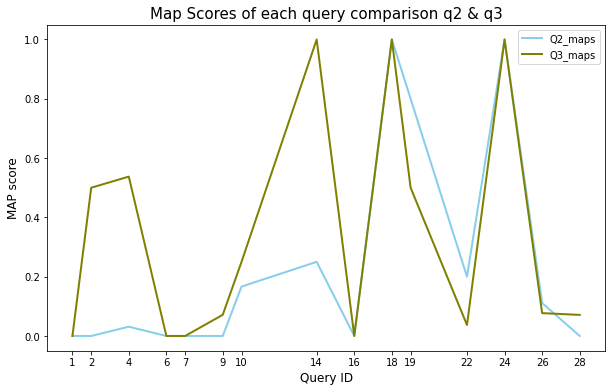

In [ ]:
q3_query_maps, q3_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q3, SEARCHER_Q3)

plt.figure(figsize=(10,6))
plt.plot( list(q2_query_maps.keys()), list(q2_query_maps.values()), color='skyblue', linewidth=2, label="Q2_maps")
plt.plot( list(q3_query_maps.keys()), list(q3_query_maps.values()), color='olive', linewidth=2, label="Q3_maps")
plt.xticks(list(q3_query_maps.keys()))
plt.xlabel('Query ID', fontsize=12)
plt.ylabel('MAP score', fontsize=12)
plt.title('Map Scores of each query comparison q2 & q3', fontsize=15)
plt.legend()

### Note 3

**Final Model Performance**
1. **map** = 0.3363

**Modification Proposed =**
1. **Lemmatization of query and content =**

This will help remove the difference between "plant" and "plants" hence will make the retrieval better

2. **Lowercasing of query and content =**

This will help remove the difference between "Nuclear" and "nuclear" hence will make the retreival better

3. **Remove stop words**

Stop words do not add much information to the query or the content, and hence must not be included for information retreival

**Improvements observed =**
1. Overall unique term count has gone down from 102,224 to 68,225
2. Occurance of the word 'nuclear' has increased from 573 to 1,042
3. Occurance of the word 'power' has increased from 680 to 1,359
4. Occurance of the word 'plant' has increased from 160 to 704
5. Distinct words are no longer stop words but informative words like 'gamma', 'health'

**Overall Performance improvement =**
1. MAP has **increased** from 0.1971 to 0.3363

**Previously chosen FP and FN inprovement**
1. In case of False Negative, it has not been improved to True Positive one
2. In case of False Positive, its score is dropped from 25.22 to 23.00 and instead of 1st rank, it is now on 3rd



The idea was good as the overall MAP increased from 0.1971 to 0.3363 and each query also showed significant improvement in terms of MAP score as displayed in the plot "Map Scores of each query comparison q2 & q3". Moreover the addition of analyser filters helped elevate scoring issues related to difference in lower vs upper cased words, and words with different forms such as "plant" and "plants".

Topic ID improved from q2 to q3 are = 

2,4,9,10,14,28

Topics which got worse are =

22,26

## 4. Search engine optimization

In [ ]:
# Put your code for creating the index here (you can add more cells).
# Make sure you save the final index in the variable INDEX_Q4, your query parser in QP_Q4, and your searcher in SEARCHER_Q4

# --------------------------------------------------------------------------------------------------------#
# 1. Searching optimal grouping techiniques                                                                       #
# --------------------------------------------------------------------------------------------------------#

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 1. Searching grouping techiniques                                                                       #
# --------------------------------------------------------------------------------------------------------#

group_list = [qparser.AndGroup, qparser.OrGroup, qparser.AndNotGroup, qparser.AndMaybeGroup, qparser.DisMaxGroup, qparser.RequireGroup, qparser.NotGroup]
group_list_str = ['AndGroup', 'OrGroup', 'AndNotGroup', 'AndMaybeGroup', 'DisMaxGroup', 'RequireGroup', 'NotGroup']
# --------------------------------------------------------------------------------------------------------#
# 1. define a Schema for the index                                                                       #
# --------------------------------------------------------------------------------------------------------#
ANALYZER_Q4_1 = RegexTokenizer() | LowercaseFilter() | StopFilter() | StemFilter()

mySchema_Q4_1 = Schema(file_path = ID(stored=True),
                  file_content = TEXT(analyzer = ANALYZER_Q4_1))

# --------------------------------------------------------------------------------------------------------#
# 2. create the index using the schema defined in 1.                                                      #
# --------------------------------------------------------------------------------------------------------#

# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_1 = createIndex(mySchema_Q4_1)

# --------------------------------------------------------------------------------------------------------#
# 3. adding the files to the index created in 2.                                                          #
# --------------------------------------------------------------------------------------------------------#

addFilesToIndex(INDEX_Q4_1, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 4. querying                                                                                             #
# --------------------------------------------------------------------------------------------------------#
Q4_1_all_map_dict = {}
for i in range(len(group_list)):
  
  # define a query parser for the field "file_content" in the index
  QP_Q4_1 = QueryParser("file_content", schema=INDEX_Q4_1.schema, group = group_list[i])
  SEARCHER_Q4_1 = INDEX_Q4_1.searcher()

  # --------------------------------------------------------------------------------------------------------#
  # 5. Evaluation using TREC_EVAL                                                                           #
  # --------------------------------------------------------------------------------------------------------#
  try:
    Q4_1_query_maps, Q4_1_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q4_1, SEARCHER_Q4_1)
  except:
    Q4_1_all_map_dict[group_list_str[i]] = 0
  Q4_1_all_map_dict[group_list_str[i]] = Q4_1_all_map

No handles with labels found to put in legend.


{'AndGroup': 0.33627366478251997,
 'AndMaybeGroup': 0.3709463247263865,
 'AndNotGroup': 0.3709463247263865,
 'DisMaxGroup': 0.14830117316759076,
 'NotGroup': 8.401500620550498e-05,
 'OrGroup': 0.3709463247263865,
 'RequireGroup': 0.14830117316759076}

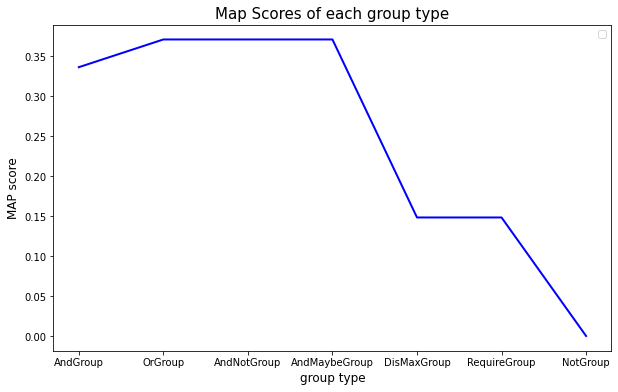

In [ ]:
plt.figure(figsize=(10,6))
plt.plot( list(Q4_1_all_map_dict.keys()), list(Q4_1_all_map_dict.values()), color='blue', linewidth=2) #label="Q2_maps"
plt.xticks(list(Q4_1_all_map_dict.keys()))
plt.xlabel('group type', fontsize=12)
plt.ylabel('MAP score', fontsize=12)
plt.title('Map Scores of each group type', fontsize=15)
plt.legend()

Q4_1_all_map_dict

### Parameter chosen

**Step1. "OrGroup"** 

As it improves performance

# --------------------------------------------------------------------------------------------------------#
# 2. Searching optimal stemmer/lemmatizer                                                           #
# --------------------------------------------------------------------------------------------------------#

In [ ]:
from whoosh.analysis import Filter
class CustomFilter(Filter):
    is_morph = True
    def __init__(self, filterFunc, *args, **kwargs):
        self.customFilter = filterFunc
        self.args = args
        self.kwargs = kwargs
    def __eq__(self):
        return (other
                and self.__class__ is other.__class__)
    def __call__(self, tokens):
        for t in tokens:
            if t.mode == 'query': # if called by query parser
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
            else: # == 'index' if called by indexer
                t.text = self.customFilter(t.text, *self.args, **self.kwargs)
                yield t
                

In [ ]:
stf = StemFilter()
ls = LancasterStemmer().stem
ps = PorterStemmer().stem
rs = RegexpStemmer('ing$|s$|e$|able$', min=4).stem
ss = SnowballStemmer("english").stem
wnl = WordNetLemmatizer().lemmatize

stem_list = [stf, ls, ps, rs, ss, wnl]
stem_list_string = ['stf', 'ls', 'ps', 'rs', 'ss', 'wnl']

Q4_2_all_map_dict = {}

for i in range(len(stem_list)):
  # --------------------------------------------------------------------------------------------------------#
  # 1. define a Schema for the index                                                                       #
  # --------------------------------------------------------------------------------------------------------#
  if stem_list[i] == stf:
    ANALYZER_Q4_2 = RegexTokenizer() | LowercaseFilter() | StopFilter() | stem_list[i]
  else:
    ANALYZER_Q4_2 = RegexTokenizer() | LowercaseFilter() | StopFilter() | CustomFilter(stem_list[i])

  mySchema_Q4_2 = Schema(file_path = ID(stored=True),
                    file_content = TEXT(analyzer = ANALYZER_Q4_2))

  # --------------------------------------------------------------------------------------------------------#
  # 2. create the index using the schema defined in 1.                                                      #
  # --------------------------------------------------------------------------------------------------------#

  # now, create the index at the path INDEX_DIR based on the new schema
  INDEX_Q4_2 = createIndex(mySchema_Q4_2)

  # --------------------------------------------------------------------------------------------------------#
  # 3. adding the files to the index created in 2.                                                          #
  # --------------------------------------------------------------------------------------------------------#

  addFilesToIndex(INDEX_Q4_2, filesToIndex)

  # --------------------------------------------------------------------------------------------------------#
  # 4. querying                                                                                             #
  # --------------------------------------------------------------------------------------------------------#
  
     
  # define a query parser for the field "file_content" in the index
  QP_Q4_2 = QueryParser("file_content", schema=INDEX_Q4_2.schema, group = qparser.OrGroup)
  SEARCHER_Q4_2 = INDEX_Q4_2.searcher()

  # --------------------------------------------------------------------------------------------------------#
  # 5. Evaluation using TREC_EVAL                                                                           #
  # --------------------------------------------------------------------------------------------------------#
  Q4_2_query_maps, Q4_2_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q4_2, SEARCHER_Q4_2)
  
  Q4_2_all_map_dict[stem_list_string[i]] = Q4_2_all_map

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.
already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.
already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.
already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.
already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.
already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


No handles with labels found to put in legend.


{'ls': 0.37954988834336295,
 'ps': 0.36946770324776507,
 'rs': 0.3737606534988713,
 'ss': 0.3697463743673973,
 'stf': 0.3709463247263865,
 'wnl': 0.37439454786114806}

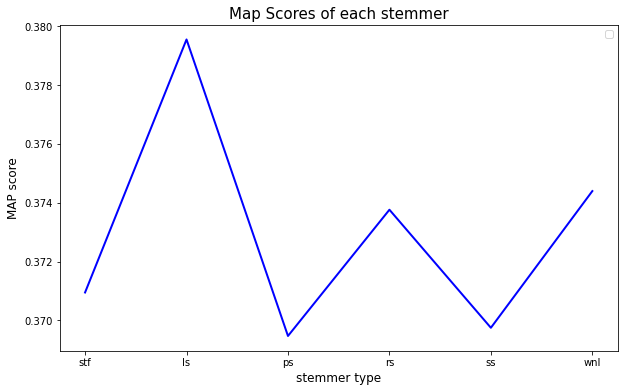

In [ ]:
plt.figure(figsize=(10,6))
plt.plot( list(Q4_2_all_map_dict.keys()), list(Q4_2_all_map_dict.values()), color='blue', linewidth=2) #label="Q2_maps"
plt.xticks(list(Q4_2_all_map_dict.keys()))
plt.xlabel('stemmer type', fontsize=12)
plt.ylabel('MAP score', fontsize=12)
plt.title('Map Scores of each stemmer', fontsize=15)
plt.legend()

Q4_2_all_map_dict

### Parameters chosen

Step1. "OrGroup" | 

**Step2. LancasterStemmer** 

As it improves performance

# --------------------------------------------------------------------------------------------------------#
# 3. Applying soft (stopwordsfilter - Porter) and hard stemmer (Lancaster) in a row                                                    #
# --------------------------------------------------------------------------------------------------------#

https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg#:~:text=At%20the%20very%20basics%20of,aggressive%20than%20the%20porter%20stemmer.&text=It%20is%20also%20the%20oldest%20stemming%20algorithm%20by%20a%20large%20margin.

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 1. define a Schema for the index                                                                       #
# --------------------------------------------------------------------------------------------------------#

ANALYZER_Q4_3 = RegexTokenizer() | LowercaseFilter() | StopFilter() | stem_list[0] | CustomFilter(stem_list[1])

mySchema_Q4_3 = Schema(file_path = ID(stored=True),
                    file_content = TEXT(analyzer = ANALYZER_Q4_3))

# --------------------------------------------------------------------------------------------------------#
# 2. create the index using the schema defined in 1.                                                      #
# --------------------------------------------------------------------------------------------------------#

# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_3 = createIndex(mySchema_Q4_3)

# --------------------------------------------------------------------------------------------------------#
# 3. adding the files to the index created in 2.                                                          #
# --------------------------------------------------------------------------------------------------------#

addFilesToIndex(INDEX_Q4_3, filesToIndex)

# --------------------------------------------------------------------------------------------------------#
# 4. querying                                                                                             #
# --------------------------------------------------------------------------------------------------------#
  
     
# define a query parser for the field "file_content" in the index
QP_Q4_3 = QueryParser("file_content", schema=INDEX_Q4_3.schema, group = qparser.OrGroup)
SEARCHER_Q4_3 = INDEX_Q4_3.searcher()

# --------------------------------------------------------------------------------------------------------#
# 5. Evaluation using TREC_EVAL                                                                           #
# --------------------------------------------------------------------------------------------------------#
Q4_3_query_maps, Q4_3_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q4_3, SEARCHER_Q4_3)


already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [ ]:
Q4_3_all_map

0.38896567636719737

### Parameters chosen

Step1. "OrGroup" | 

Step2. LancasterStemmer | 

**Step3. StemFilter and Lancaster stemmer in sequence** 

As it improves performance

# --------------------------------------------------------------------------------------------------------#
# 4. Applying query plugins               #
# --------------------------------------------------------------------------------------------------------#

In [ ]:
plugin_list = [qparser.FuzzyTermPlugin(), qparser.SequencePlugin(), qparser.OperatorsPlugin(And="and", Or="or", AndNot="&!", AndMaybe="&~", Not="\\-")]
plugin_list_str = ['FuzzyTermPlugin()', 'SequencePlugin()', 'OperatorsPlugin()']

# --------------------------------------------------------------------------------------------------------#
# 1. define a Schema for the index                                                                       #
# --------------------------------------------------------------------------------------------------------#

ANALYZER_Q4_4 = RegexTokenizer() | LowercaseFilter() | StopFilter() | stem_list[0] | CustomFilter(stem_list[1])

mySchema_Q4_4 = Schema(file_path = ID(stored=True),
                    file_content = TEXT(analyzer = ANALYZER_Q4_4))

# --------------------------------------------------------------------------------------------------------#
# 2. create the index using the schema defined in 1.                                                      #
# --------------------------------------------------------------------------------------------------------#

# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_4 = createIndex(mySchema_Q4_4)

# --------------------------------------------------------------------------------------------------------#
# 3. adding the files to the index created in 2.                                                          #
# --------------------------------------------------------------------------------------------------------#

addFilesToIndex(INDEX_Q4_4, filesToIndex)

# --------------------------------------------------------------------------------------------------------#
# 4. querying                                                                                             #
# --------------------------------------------------------------------------------------------------------#
Q4_4_all_map_dict = {}
for i in range(len(plugin_list)):

  # define a query parser for the field "file_content" in the index
  QP_Q4_4 = QueryParser("file_content", schema=INDEX_Q4_3.schema, group = qparser.OrGroup)
  QP_Q4_4.add_plugin(plugin_list[i])

  SEARCHER_Q4_4 = INDEX_Q4_4.searcher()

  # --------------------------------------------------------------------------------------------------------#
  # 5. Evaluation using TREC_EVAL                                                                           #
  # --------------------------------------------------------------------------------------------------------#
  Q4_4_query_maps, Q4_4_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q4_4, SEARCHER_Q4_4)
  Q4_4_all_map_dict[plugin_list_str[i]] = Q4_4_all_map

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


No handles with labels found to put in legend.


{'FuzzyTermPlugin()': 0.38896567636719737,
 'OperatorsPlugin()': 0.38730854999906483,
 'SequencePlugin()': 0.38896567636719737}

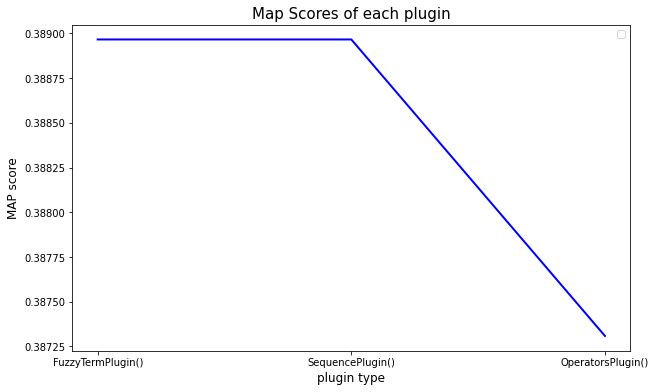

In [ ]:
plt.figure(figsize=(10,6))
plt.plot( list(Q4_4_all_map_dict.keys()), list(Q4_4_all_map_dict.values()), color='blue', linewidth=2) #label="Q2_maps"
plt.xticks(list(Q4_4_all_map_dict.keys()))
plt.xlabel('plugin type', fontsize=12)
plt.ylabel('MAP score', fontsize=12)
plt.title('Map Scores of each plugin', fontsize=15)
plt.legend()

Q4_4_all_map_dict

### Parameters chosen

Step1. "OrGroup" | 

Step2. LancasterStemmer | 

Step3. StemFilter and Lancaster stemmer in sequence

**Step4. None** 

Plugin didnot improve any performance

# --------------------------------------------------------------------------------------------------------#
# 5. Applying more analyser filters               #
# --------------------------------------------------------------------------------------------------------#

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 1. define a Schema for the index                                                                       #
# --------------------------------------------------------------------------------------------------------#

ANALYZER_Q4_5 = RegexTokenizer() | LowercaseFilter() | SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter() |  StopFilter() | stem_list[0] | CustomFilter(stem_list[1])

mySchema_Q4_5 = Schema(file_path = ID(stored=True),
                    file_content = TEXT(analyzer = ANALYZER_Q4_5))

# --------------------------------------------------------------------------------------------------------#
# 2. create the index using the schema defined in 1.                                                      #
# --------------------------------------------------------------------------------------------------------#

# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_5 = createIndex(mySchema_Q4_5)

# --------------------------------------------------------------------------------------------------------#
# 3. adding the files to the index created in 2.                                                          #
# --------------------------------------------------------------------------------------------------------#

addFilesToIndex(INDEX_Q4_5, filesToIndex)

# --------------------------------------------------------------------------------------------------------#
# 4. querying                                                                                             #
# --------------------------------------------------------------------------------------------------------#
  
     
# define a query parser for the field "file_content" in the index
QP_Q4_5 = QueryParser("file_content", schema=INDEX_Q4_5.schema, group = qparser.OrGroup)
SEARCHER_Q4_5 = INDEX_Q4_5.searcher()

# --------------------------------------------------------------------------------------------------------#
# 5. Evaluation using TREC_EVAL                                                                           #
# --------------------------------------------------------------------------------------------------------#
Q4_5_query_maps, Q4_5_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q4_5, SEARCHER_Q4_5)


already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [ ]:
Q4_5_all_map

0.3895881826222695

### Parameters chosen

Step1. "OrGroup" | 

Step2. LancasterStemmer | 

Step3. StemFilter and Lancaster stemmer in sequence

Step4. None

**Step5. add analyser filters = SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter()** 

As they improve any performance

# --------------------------------------------------------------------------------------------------------#
# 6. Searching for optimal scoring               #
# --------------------------------------------------------------------------------------------------------#

https://www.elastic.co/blog/practical-bm25-part-2-the-bm25-algorithm-and-its-variables
https://whoosh.readthedocs.io/en/latest/api/scoring.html?highlight=bm25f

In [ ]:
from whoosh import scoring

scoring_list = [scoring.BM25F(), scoring.TF_IDF(), scoring.Frequency()]
scoring_list_str = ['BM25F()', 'TF_IDF()', 'Frequency()']

# --------------------------------------------------------------------------------------------------------#
# 1. define a Schema for the index                                                                       #
# --------------------------------------------------------------------------------------------------------#

ANALYZER_Q4_6 = RegexTokenizer() | LowercaseFilter() | SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter() |  StopFilter() | stem_list[0] | CustomFilter(stem_list[1])

mySchema_Q4_6 = Schema(file_path = ID(stored=True),
                    file_content = TEXT(analyzer = ANALYZER_Q4_6))

# --------------------------------------------------------------------------------------------------------#
# 2. create the index using the schema defined in 1.                                                      #
# --------------------------------------------------------------------------------------------------------#

# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_6 = createIndex(mySchema_Q4_6)

# --------------------------------------------------------------------------------------------------------#
# 3. adding the files to the index created in 2.                                                          #
# --------------------------------------------------------------------------------------------------------#

addFilesToIndex(INDEX_Q4_6, filesToIndex)

# --------------------------------------------------------------------------------------------------------#
# 4. querying                                                                                             #
# --------------------------------------------------------------------------------------------------------#
Q4_6_all_map_dict = {}

for i in range(len(scoring_list)):

  # define a query parser for the field "file_content" in the index
  QP_Q4_6 = QueryParser("file_content", schema=INDEX_Q4_6.schema, group = qparser.OrGroup)
  w = scoring_list[i]
  SEARCHER_Q4_6 = INDEX_Q4_6.searcher(weighting = w)

  # --------------------------------------------------------------------------------------------------------#
  # 5. Evaluation using TREC_EVAL                                                                           #
  # --------------------------------------------------------------------------------------------------------#
  Q4_6_query_maps, Q4_6_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q4_6, SEARCHER_Q4_6)
  Q4_6_all_map_dict[scoring_list_str[i]] = Q4_6_all_map

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


No handles with labels found to put in legend.


{'BM25F()': 0.3895881826222695,
 'Frequency()': 0.1064753722214371,
 'TF_IDF()': 0.13245901808663382}

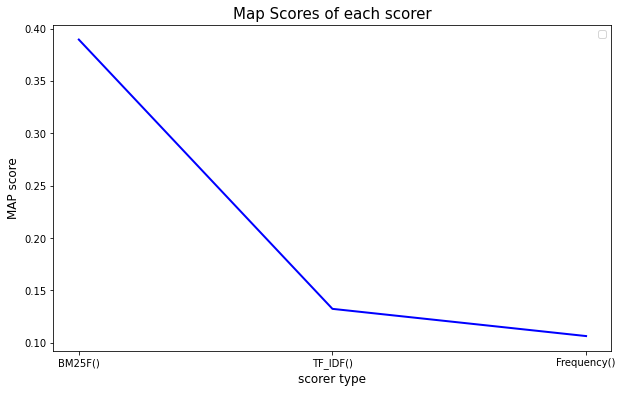

In [ ]:
plt.figure(figsize=(10,6))
plt.plot( list(Q4_6_all_map_dict.keys()), list(Q4_6_all_map_dict.values()), color='blue', linewidth=2) #label="Q2_maps"
plt.xticks(list(Q4_6_all_map_dict.keys()))
plt.xlabel('scorer type', fontsize=12)
plt.ylabel('MAP score', fontsize=12)
plt.title('Map Scores of each scorer', fontsize=15)
plt.legend()

Q4_6_all_map_dict

### Parameters chosen

Step1. "OrGroup" | 

Step2. LancasterStemmer | 

Step3. StemFilter and Lancaster stemmer in sequence

Step4. None

Step5. add analyser filters = SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter()

**Step6. Optimal scorers = BM25** 

As they improve any performance

# --------------------------------------------------------------------------------------------------------#
# 7. Tuning scorer               #
# --------------------------------------------------------------------------------------------------------#

https://www.elastic.co/blog/practical-bm25-part-2-the-bm25-algorithm-and-its-variables
https://whoosh.readthedocs.io/en/latest/api/scoring.html?highlight=bm25f

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 1. define a Schema for the index                                                                       #
# --------------------------------------------------------------------------------------------------------#

ANALYZER_Q4_7 = RegexTokenizer() | LowercaseFilter() | SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter() |  StopFilter() | stem_list[0] | CustomFilter(stem_list[1])

mySchema_Q4_7 = Schema(file_path = ID(stored=True),
                    file_content = TEXT(analyzer = ANALYZER_Q4_7))

# --------------------------------------------------------------------------------------------------------#
# 2. create the index using the schema defined in 1.                                                      #
# --------------------------------------------------------------------------------------------------------#

# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_7 = createIndex(mySchema_Q4_7)

# --------------------------------------------------------------------------------------------------------#
# 3. adding the files to the index created in 2.                                                          #
# --------------------------------------------------------------------------------------------------------#

addFilesToIndex(INDEX_Q4_7, filesToIndex)


already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [ ]:
B_values = np.arange(0.530,0.550,0.001)
K1_values = np.arange(2.560,2.580,0.001)

# --------------------------------------------------------------------------------------------------------#
# 4. querying                                                                                             #
# --------------------------------------------------------------------------------------------------------#
Q4_7_all_map_dict = {}

count_Q4_7 = 0
for B in range(len(B_values)):
  for K in range(len(K1_values)):

    # define a query parser for the field "file_content" in the index
    QP_Q4_7 = QueryParser("file_content", schema=INDEX_Q4_7.schema, group = qparser.OrGroup)
    w = scoring.BM25F(B = B_values[B], K1 = K1_values[K])
    SEARCHER_Q4_7 = INDEX_Q4_7.searcher(weighting = w)

    # --------------------------------------------------------------------------------------------------------#
    # 5. Evaluation using TREC_EVAL                                                                           #
    # --------------------------------------------------------------------------------------------------------#
    Q4_7_query_maps, Q4_7_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q4_7, SEARCHER_Q4_7)
    Q4_7_all_map_dict[(B_values[B],K1_values[K])] = Q4_7_all_map

    count_Q4_7 += 1
    if count_Q4_7%100 == 0:
      print(count_Q4_7, 'iterations done')

100 iterations done
200 iterations done
300 iterations done
400 iterations done


In [ ]:
best_BK_param_Q4_7 = max(Q4_7_all_map_dict, key=Q4_7_all_map_dict.get)
print('best B,K values are', best_BK_param_Q4_7)

best B,K values are (0.534, 2.5719999999999987)


In [ ]:
all_values = Q4_7_all_map_dict.values()
print ('Map score after tuning is =', max(all_values))

Map score after tuning is = 0.409919562394266


### Parameters chosen

Step1. "OrGroup" | 

Step2. LancasterStemmer | 

Step3. StemFilter and Lancaster stemmer in sequence

Step4. None

Step5. add analyser filters = SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter()

Step6. Optimal scorers = BM25F

**Step7. Scorer Tuning = BM25F B = 0.534, K=2.572**

As they improve any performance

# --------------------------------------------------------------------------------------------------------#
# 8. Using wordnet NLTK stop words               #
# --------------------------------------------------------------------------------------------------------#

In [ ]:
nltk.download('stopwords')
stopwords_Q4_8 = list(set(stopwords.words('english')))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 1. define a Schema for the index                                                                       #
# --------------------------------------------------------------------------------------------------------#

ANALYZER_Q4_8 = RegexTokenizer() | LowercaseFilter() | SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter() |  StopFilter(stoplist=stopwords_Q4_8) | stem_list[0] | CustomFilter(stem_list[1])

mySchema_Q4_8 = Schema(file_path = ID(stored=True),
                    file_content = TEXT(analyzer = ANALYZER_Q4_8))

# --------------------------------------------------------------------------------------------------------#
# 2. create the index using the schema defined in 1.                                                      #
# --------------------------------------------------------------------------------------------------------#

# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4_8 = createIndex(mySchema_Q4_8)

# --------------------------------------------------------------------------------------------------------#
# 3. adding the files to the index created in 2.                                                          #
# --------------------------------------------------------------------------------------------------------#

addFilesToIndex(INDEX_Q4_8, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 4. querying                                                                                             #
# --------------------------------------------------------------------------------------------------------#
# define a query parser for the field "file_content" in the index
QP_Q4_8 = QueryParser("file_content", schema=INDEX_Q4_8.schema, group = qparser.OrGroup)
w_Q4_8 = scoring.BM25F(B = best_BK_param_Q4_7[0], K1 = best_BK_param_Q4_7[1])
SEARCHER_Q4_8 = INDEX_Q4_8.searcher(weighting = w_Q4_8)

# --------------------------------------------------------------------------------------------------------#
# 5. Evaluation using TREC_EVAL                                                                           #
# --------------------------------------------------------------------------------------------------------#
Q4_8_query_maps, Q4_8_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q4_8, SEARCHER_Q4_8)

In [ ]:
Q4_8_all_map

0.4098604944780552

### Parameters chosen

Step1. "OrGroup" | 

Step2. LancasterStemmer | 

Step3. StemFilter and Lancaster stemmer in sequence

Step4. None

Step5. add analyser filters = SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter()

Step6. Optimal scorers = BM25F

**Step7. Scorer Tuning = BM25F B = 0.534, K=2.572**

**Step8. Scorer Tuning = BM25F B = 0.534, K=2.572**


As they improve any performance

# --------------------------------------------------------------------------------------------------------#
# ** FINAL MODEL **               #
# --------------------------------------------------------------------------------------------------------#

In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 1. define a Schema for the index                                                                       #
# --------------------------------------------------------------------------------------------------------#

ANALYZER_Q4 = RegexTokenizer() | LowercaseFilter() | SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter() |  StopFilter() | stem_list[0] | CustomFilter(stem_list[1])

mySchema_Q4 = Schema(file_path = ID(stored=True),
                    file_content = TEXT(analyzer = ANALYZER_Q4))

# --------------------------------------------------------------------------------------------------------#
# 2. create the index using the schema defined in 1.                                                      #
# --------------------------------------------------------------------------------------------------------#

# now, create the index at the path INDEX_DIR based on the new schema
INDEX_Q4 = createIndex(mySchema_Q4)

# --------------------------------------------------------------------------------------------------------#
# 3. adding the files to the index created in 2.                                                          #
# --------------------------------------------------------------------------------------------------------#

addFilesToIndex(INDEX_Q4, filesToIndex)

already indexed: 1000
already indexed: 2000
already indexed: 3000
already indexed: 4000
done indexing.


In [ ]:
# --------------------------------------------------------------------------------------------------------#
# 4. querying                                                                                             #
# --------------------------------------------------------------------------------------------------------#

# define a query parser for the field "file_content" in the index
QP_Q4 = QueryParser("file_content", schema=INDEX_Q4.schema, group = qparser.OrGroup)
w_Q4 = scoring.BM25F(B = 0.534, K1 = 2.572)
SEARCHER_Q4 = INDEX_Q4.searcher(weighting = w_Q4)

# --------------------------------------------------------------------------------------------------------#
# 5. Evaluation using TREC_EVAL                                                                           #
# --------------------------------------------------------------------------------------------------------#
Q4_query_maps, Q4_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q4, SEARCHER_Q4)
pyTrecEval(TOPIC_FILE, QRELS_FILE, QP_Q4, SEARCHER_Q4)

num_q                    1       1.0000
num_ret                  1       468.0000
num_rel                  1       5.0000
num_rel_ret              1       5.0000
map                      1       0.0655
gm_map                   1       -2.7262
Rprec                    1       0.0000
bpref                    1       0.0000
recip_rank               1       0.0526
iprec_at_recall_0.00     1       0.1034
iprec_at_recall_0.10     1       0.1034
iprec_at_recall_0.20     1       0.1034
iprec_at_recall_0.30     1       0.1034
iprec_at_recall_0.40     1       0.1034
iprec_at_recall_0.50     1       0.1034
iprec_at_recall_0.60     1       0.1034
iprec_at_recall_0.70     1       0.0500
iprec_at_recall_0.80     1       0.0500
iprec_at_recall_0.90     1       0.0472
iprec_at_recall_1.00     1       0.0472
P_5                      1       0.0000
P_10                     1       0.0000
P_15                     1       0.0000
P_20                     1       0.0500
P_30                     1       0.10

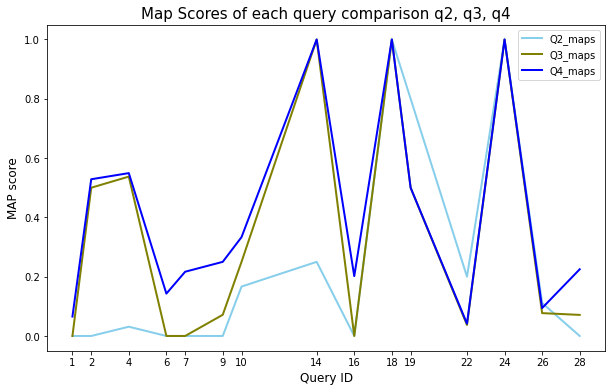

In [ ]:
# q3_query_maps, q3_all_map = pyTrecEvalmodified_map(TOPIC_FILE, QRELS_FILE, QP_Q3, SEARCHER_Q3)

plt.figure(figsize=(10,6))
plt.plot( list(q2_query_maps.keys()), list(q2_query_maps.values()), color='skyblue', linewidth=2, label="Q2_maps")
plt.plot( list(q3_query_maps.keys()), list(q3_query_maps.values()), color='olive', linewidth=2, label="Q3_maps")
plt.plot( list(Q4_query_maps.keys()), list(Q4_query_maps.values()), color='blue', linewidth=2, label="Q4_maps")

plt.xticks(list(q3_query_maps.keys()))
plt.xlabel('Query ID', fontsize=12)
plt.ylabel('MAP score', fontsize=12)
plt.title('Map Scores of each query comparison q2, q3, q4', fontsize=15)
plt.legend()

Improvement across all query MAP observed in the plot above

No handles with labels found to put in legend.


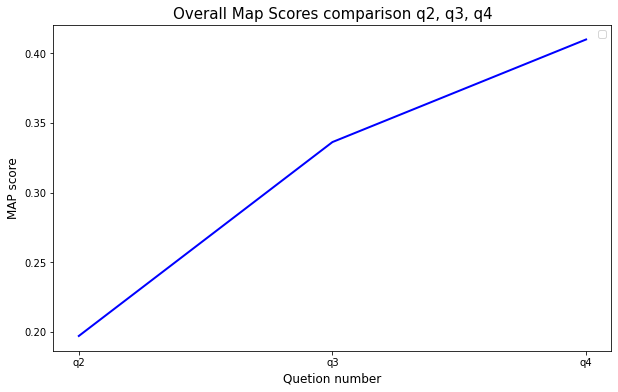

In [ ]:
plt.figure(figsize=(10,6))
plt.plot( ['q2', 'q3', 'q4'], [q2_all_map,q3_all_map,Q4_all_map], color='blue', linewidth=2)
plt.xlabel('Quetion number', fontsize=12)
plt.ylabel('MAP score', fontsize=12)
plt.title('Overall Map Scores comparison q2, q3, q4', fontsize=15)
plt.legend()

In [ ]:
printRelName(TOPIC_FILE, QRELS_FILE, QP_Q4, SEARCHER_Q4, "26")

---------------------------Topic_id and Topic_phrase----------------------------------
26 Nuclear power plants
---------------------------Return documents----------------------------------
26 Q0 G00-76-3273936 0 35.027422 test
26 Q0 G00-61-1118212 1 34.006249 test
26 Q0 G00-28-2250792 2 33.473772 test
26 Q0 G00-72-1085257 3 32.435201 test
26 Q0 G00-30-0129773 4 31.308249 test
26 Q0 G00-13-1543158 5 30.444481 test
26 Q0 G00-01-3645577 6 30.060505 test
26 Q0 G00-30-1518511 7 29.814419 test
26 Q0 G00-84-2503293 8 29.386494 test
26 Q0 G00-50-1075346 9 28.576504 test
26 Q0 G00-62-1736084 10 27.609246 test
26 Q0 G00-49-0195605 11 27.321788 test
26 Q0 G00-11-1650256 12 27.135367 test
26 Q0 G00-73-1499832 13 27.037091 test
26 Q0 G00-53-1684082 14 26.981689 test
26 Q0 G00-50-2186799 15 26.958157 test
26 Q0 G00-14-1375985 16 26.500424 test
26 Q0 G00-15-0501460 17 25.735823 test
26 Q0 G00-35-0922387 18 25.678471 test
26 Q0 G00-64-3503951 19 25.399090 test
26 Q0 G00-97-1443049 20 25.184046 test
26

## For query 26

### q3

---------------------------Relevant documents----------------------------------

26 0 G00-01-1806077 1 (False Negative)

26 0 G00-01-3645577 1 (True Positive)

26 0 G00-92-1620651 1 (True Positive)

### q4
---------------------------Relevant documents----------------------------------

26 0 G00-01-1806077 1 (True Positive)

26 0 G00-01-3645577 1 (True Positive)

26 0 G00-92-1620651 1 (True Positive)

**Hence the number of false negative for query 26 has gone to zero and from the plot above, its MAP has been improved**

### Note 4
**(a) A clear list of all final modifications made.**

All Iterations are

1. Using "OrGroup" for query parsing
2. Using "Lancaster Stemmer" for analyzer
3. Using "Stemfilter + Lancaster Stemmer" for analyzer
4. Using "Plugins" for query searcher
5. Using "SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter()" for analyzer
6. Using "BM25 Scorer" for searching
7. Using "BM25 Tuned Scorer" for searching
8. Using "NLTK stopwords" for analyzer

The ones worked are

1. Using "OrGroup" for query parsing
3. Using "Stemfilter + Lancaster Stemmer" for analyzer
5. Using "SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter()" for analyzer
7. Using "BM25 Tuned Scorer" for searching

**(b)  Why each modification was made – how did it help?**  

1. Using "OrGroup" for query parsing

  Why? = 

  The parser by default takes the spaces as a "AND" clause and then searches and ranks the document based on the query. Such as in false negative case analysed, the document didnot contain "plant" (Query - Nuclear power plant), but was a relevant document. Hence "OR" clause is needed to eliminate this case.

  Benefits = 

  "OR" clause in the searches made it more leniant instant on being strict like that of the "AND" clause and hence would result in improvement of the MAP from 0.3363 to 0.3709

  .
  
2. Using "Stemfilter + Lancaster Stemmer" for analyzer

  Why? =

  Stemming is important as the words like "plant" and "plants" have the same meaning but can be indexed differently. Moreover, Stemfilter by whoosh uses portstemmer algorithim and is very lineant. It doesnot perform stemming on many words like "are", "be" whereas the lancaster stemming is a very strong stemmer which would help avoid the issue.

  Benefits = 

  The combination of lancaster and stopfilter helped collapse the multiple forms of a word like "plant" and "plants" into a single term. This would allow the searcher to score the documents better and not be misguided by the word form. hence would result in improvement of the MAP from 0.3709 to 0.3889 

  .
  
3. Using "SubstitutionFilter(r"\d+","") | IntraWordFilter() | StripFilter()" for analyzer

  Why? = 

  The words like "nuclear-power" or numeric combination terms would be missed out by our searcher because of the special characters inbetween meaningful words.

  Benefits = 

  The substitution filter help identify and remove the numbers. Moreover the Itnraword filter and the Stripfilter helped to tokenise the words like nuclear-power or tele-communication better. This reduced the unique word index and helped increase the importance of informative rare words. Hence would result in improvement of the MAP from 0.3889 to 0.3895

  .
  
4. Using "BM25 Tuned Scorer" for searching

  Why? = 

  The BM25F scorer is the default scorer for the whoosh searcher. However it was important to know that the other scoring methods like TFIDF and frequency had an effect on the scoring and hence the MAP. Moreover once the BM25F was identified as the best scorer for the searcher, it was important to optimize the hyperparameter namely B and K1. B governs how much score is affected by the length of the document wheras the K1 governs that affect on the score based on the term frequency in the document. If the term is rare, the K1 value quickly boosts the score while if the term is recurrent (tf>K1) then the score is quickly reduced.

  https://www.elastic.co/blog/practical-bm25-part-2-the-bm25-algorithm-and-its-variables https://whoosh.readthedocs.io/en/latest/api/scoring.html?highlight=bm25f

  https://www.elastic.co/blog/practical-bm25-part-2-the-bm25-algorithm-and-its-variables https://whoosh.readthedocs.io/en/latest/api/scoring.html?highlight=bm25f

  Benefits = 
  
  After going though over 400 iteration, the best B and K1 values were  B = 0.534, K=2.572 and the MAP score increased form 0.3895 to 0.4099

**(c) The final MAP performance that these modifications attained.**

  ## 0.4099



In [ ]:
# INDEX_Q4 = INDEX_Q4_7 # Replace None with your index for Q4
# QP_Q4 = QP_Q4_7 # Replace None with your query parser for Q4
# SEARCHER_Q4 = SEARCHER_Q4_7 # Replace None with your searcher for Q4

## Validation

In [ ]:
# Run the following cells to make sure your code returns the correct value types

In [ ]:
from whoosh.index import FileIndex
from whoosh.qparser import QueryParser
from whoosh.searching import Searcher
import os.path

### Q2 Validation

In [ ]:
assert(isinstance(INDEX_Q2, FileIndex)), "Index Type"
assert(isinstance(QP_Q2, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q2, Searcher)), "Searcher Type"
print("Q2 Types Validated")

Q2 Types Validated


### Q3 Validation

In [ ]:
assert(isinstance(INDEX_Q3, FileIndex)), "Index Type"
assert(isinstance(QP_Q3, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q3, Searcher)), "Searcher Type"
print("Q3 Types Validated")

Q3 Types Validated


### Q4 Validation

In [ ]:
assert(isinstance(INDEX_Q4, FileIndex)), "Index Type"
assert(isinstance(QP_Q4, QueryParser)), "Query Parser Type"
assert(isinstance(SEARCHER_Q4, Searcher)), "Searcher Type"
print("Q4 Types Validated")

Q4 Types Validated
